# FALTA BALANCEAR EL DATASET

# Importing libraries

In [1]:
import time
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

# Importing data and proccessing them

### Input

In [2]:
df = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics\Migraine1.csv')
df2 = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics\Migraine2.csv')
features_ = ["pain"] #Array!! Time features that you want to analyze
timestep = 16 #from 1 to 23 (17 with the current NaN strategy)
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df.drop(df.tail(30).index, inplace=True)

In [3]:
random=np.random.rand(df["pain"].size)
df["random"]=random

df=(df-df.mean())/df.std()

In [13]:
df["inventada4"]=df["relative_velocity_t"]*df["time_to_tca"]*86400
df["inventada4"]=df["time_to_tca"]*df["c_time_lastob_end"]


In [14]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))

df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

#Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Selecting features
features_.insert(0, 'event_id')
df = df[features_]

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns
X = np.zeros((events,timestep,features))
i = 0

def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#Reshaping again to 2D array but now events are filled
X = X.reshape(X.shape[0], timestep*X.shape[2])

#Naming shifted columns
shifted_columns = []
original_columns = list(df.columns)[1:] #Dropping event_id

for i in range(timestep-1,-1,-1):
    for column in original_columns: 
        shifted_columns.append(column+"_t-"+str(i))
        
#Creating df from reshape array and shifted column names
X = pd.DataFrame(X, columns=shifted_columns)

print(X.shape, y.shape)

(7311, 16) (7311, 1)


# Filter: Univariate Selection
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

,Feature,Score,p-values
16,maxTEMP30,199.462948,3.467313e-42
14,maxTEMP15,172.233753,5.347618e-37
11,stdHR30,86.570763,5.684162e-20
5,meanHR30,83.201085,2.809309e-19
23,minHR30,83.201085,2.809309e-19
10,stdTEMP30,82.714200,3.540250e-19
17,maxHR30,72.218958,5.303748e-17
12,maxTEMP5,71.920636,6.119619e-17
9,stdHR15,66.784515,7.232858e-16
15,maxHR15,63.190067,4.102683e-15


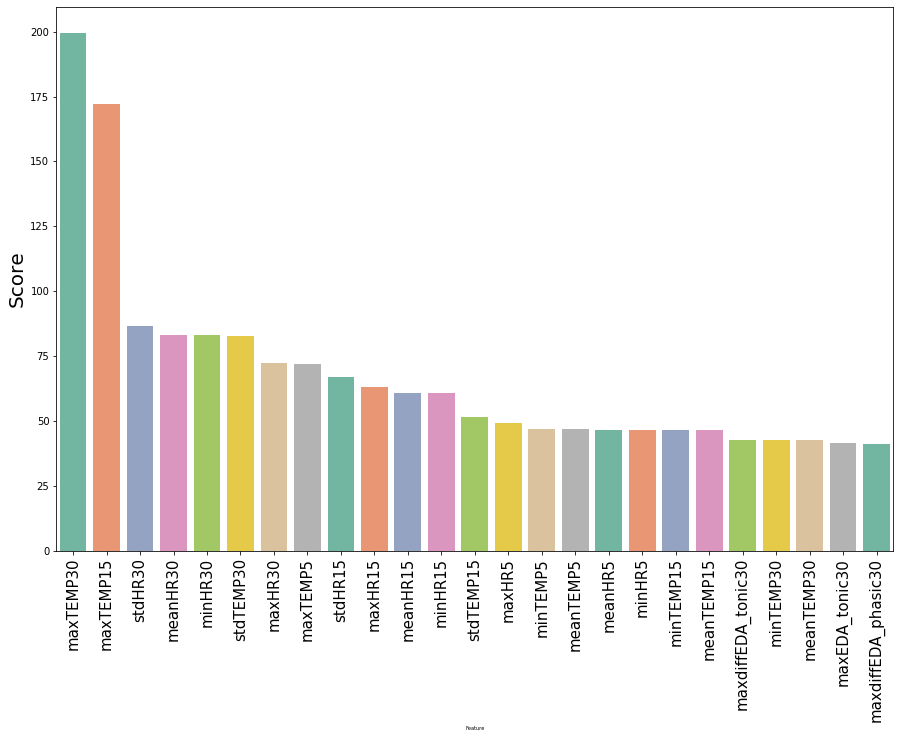

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

score_func = f_regression
k = 3
show_df = 66
show_plot = 25
X=df.loc[:, df.columns != 'pain']
#Applying SelectKBest to extract the 10 best features
bestfeatures = SelectKBest(score_func=score_func, k=k)
fit = bestfeatures.fit(X,df['pain'])

#Concatenating dataframes for better visualization
dfscores = pd.DataFrame(fit.scores_)
dfpvalues = pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
featureScores.columns = ['Feature','Score',"p-values"]

#Printing and plotting the best features
feature_sorted = featureScores.sort_values("Score",ascending=False)
display(feature_sorted.head(show_df))

for col in ["Score"]: #,"p-values"]:
    plt.figure(figsize=(15,10))
    ax = sns.barplot(x='Feature', y=col, data=feature_sorted.iloc[:show_plot], palette="Set2")
    ax.set_xticklabels(feature_sorted['Feature'],rotation=90, fontsize=15)
    ax.set_xlabel("Feature",fontsize=5)
    ax.set_ylabel(col,fontsize=20)
    plt.show


# Wrapper: Recursive Feature Elimination

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


model = RandomForestRegressor()
n_features_to_select = 5
step = 10
show_df = 111

rfe_selector = RFE(estimator=model,
                   n_features_to_select=n_features_to_select,
                   step=step
                  )
rfe_selector.fit(X, df['pain'])

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
ranking = sorted(zip(rfe_selector.ranking_, X.columns))

print("Top features:")
for feature in ranking[:show_df]:
    print(feature)

C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

Top features:
(1, 'maxEDA_smna30')
(1, 'maxEDA_tonic5')
(1, 'maxHR30')
(1, 'maxTEMP30')
(1, 'maxdiffEDA_phasic30')
(2, 'maxEDA_tonic15')
(2, 'maxdiffEDA_tonic30')
(3, 'maxEDA_phasic30')
(3, 'maxEDA_tonic30')
(3, 'meanEDA_phasic30')
(3, 'meanEDA_tonic15')
(3, 'meanEDA_tonic30')
(3, 'meanHR30')
(3, 'meanHR5')
(3, 'meanTEMP5')
(3, 'minHR30')
(3, 'stdEDA_tonic30')
(4, 'maxTEMP15')
(4, 'meanEDA_phasic15')
(4, 'meanTEMP15')
(4, 'meanTEMP30')
(4, 'minEDA_phasic15')
(4, 'minEDA_phasic30')
(4, 'minEDA_tonic30')
(4, 'minEDA_tonic5')
(4, 'minTEMP5')
(4, 'stdHR15')
(5, 'maxEDA_smna5')
(5, 'maxdiffHR30')
(5, 'maxdiffTEMP30')
(5, 'meanEDA_tonic5')
(5, 'minHR15')
(5, 'stdEDA_phasic15')
(5, 'stdEDA_tonic15')
(5, 'stdHR30')
(5, 'stdTEMP15')
(5, 'stdTEMP30')
(6, 'maxEDA_phasic15')
(6, 'maxHR15')
(6, 'maxHR5')
(6, 'maxTEMP5')
(6, 'maxdiffEDA_phasic15')
(6, 'minEDA_tonic15')
(6, 'minHR5')
(6, 'minTEMP15')
(6, 'minTEMP30')
(6, 'stdEDA_phasic30')
(7, 'countEDA_smna5')
(7, 'maxEDA_phasic5')
(7, 'maxdiffEDA_p

C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Wrapper: CV-RFE

In [28]:
#RFE with CV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error  
from sklearn.metrics import make_scorer

mse=make_scorer(mean_squared_error)
model = LinearRegression()
k_fold = 5

#SVC IS REALLY SLOW!!!
# Creating the RFE object and computing a cross-validated score.
rfecv = RFECV(estimator=model,
              step=1,
              cv=KFold(k_fold),
              scoring=mse,
              verbose=1,
             )
#X_=X[["risk","c_obs_used", "c_object_type_UNKNOWN", "miss_distance", "c_sigma_ndot"]]
rfecv.fit(X, y)

rfe_support = rfecv.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
ranking = sorted(zip(rfecv.ranking_, X.columns))

print(rfe_feature)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Top features:")
for feature in ranking[:rfecv.n_features_]:
    print(feature)

plt.figure(figsize=(15,10))
sns.set()
ax = sns.lineplot(x=range(1, len(rfecv.grid_scores_) + 1), y=rfecv.grid_scores_, palette="Set2")
ax.set_xlabel('Number of Features',fontsize=20)
ax.set_ylabel('CV Score (Accuracy)',fontsize=20)

plt.show()

C:\Users\Carlos\Anaconda3\envs\Carlosconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.

# Embedded: Feature Importance
https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

,Feature,Importance
16,maxTEMP30,2.779670e-01
52,maxEDA_tonic15,1.619814e-01
17,maxHR30,1.510748e-01
65,maxEDA_smna30,1.194834e-01
44,maxdiffEDA_phasic30,1.025690e-01
49,stdEDA_tonic15,2.848520e-02
59,maxdiffEDA_tonic30,2.772537e-02
27,maxdiffHR15,2.444142e-02
53,maxEDA_tonic30,2.371770e-02
5,meanHR30,1.959784e-02


<function matplotlib.pyplot.show(*args, **kw)>

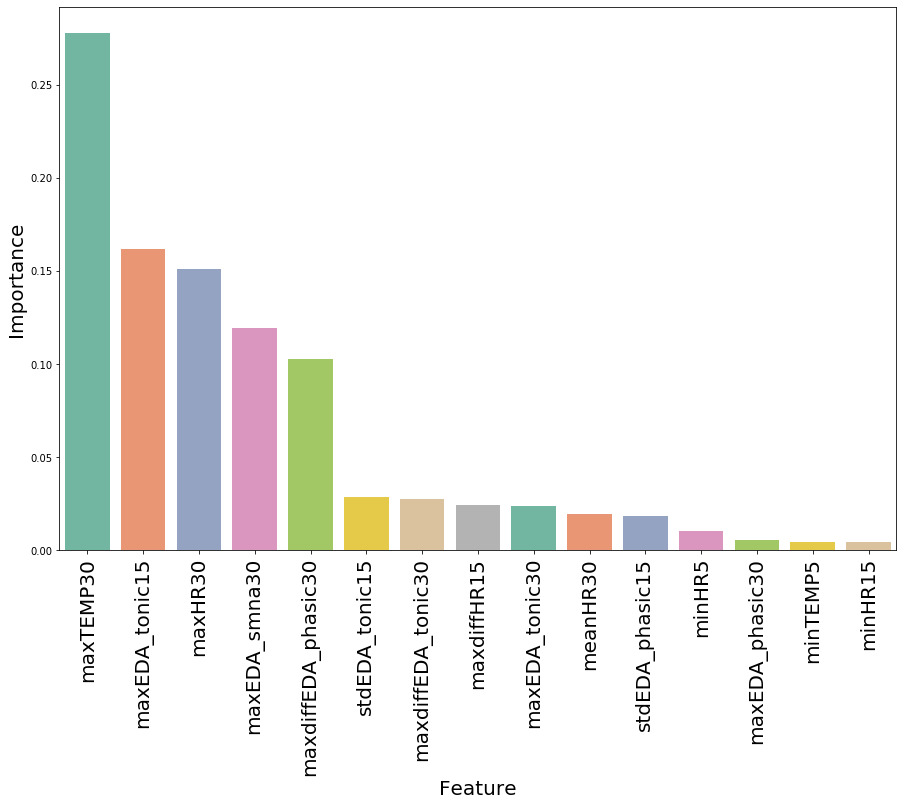

In [8]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
show_df = 100
show_plot = 15

#Using inbuilt class feature_importances of tree based classifiers
model.fit(X,df['pain'])

#Creating dataset of feature importances for better visualization
dfimportance = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(X.columns)
feat_importances = pd.concat([dfcolumns,dfimportance],axis=1)
feat_importances.columns = ['Feature','Importance']

#Displaying it
df_sort = feat_importances.sort_values("Importance",ascending=False)
display(df_sort.head(show_df))

plt.figure(figsize=(15,10))
ax = sns.barplot(x='Feature', y='Importance', data=df_sort.iloc[:show_plot], palette="Set2")
ax.set_xticklabels(df_sort['Feature'],rotation=90, fontsize=20)
ax.set_xlabel('Feature',fontsize=20)
ax.set_ylabel('Importance',fontsize=20)
plt.show

# Embedded: Select from Model

In [56]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso

model = Ridge()
max_features = 50 

embeded_lr_selector = SelectFromModel(model,
                                      max_features=max_features)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
for feature in embeded_lr_feature:
    print(feature)
    

time_to_tca
max_risk_estimate
max_risk_scaling
t_time_lastob_start
t_recommended_od_span
c_actual_od_span
c_obs_used
c_weighted_rms
c_cd_area_over_mass
c_cr_area_over_mass
c_sedr
c_j2k_ecc
c_cn_t
c_crdot_t
c_crdot_n
t_span
c_span
elevation
c_sigma_t
c_sigma_rdot
event_length


In [5]:
cor=df.corr()

In [20]:
indices = np.where(cor > 0.95)
indices = [(cor.index[x], cor.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices                                        

[('meanTEMP1', 'meanTEMP5'),
 ('meanTEMP1', 'maxTEMP1'),
 ('meanTEMP1', 'minTEMP1'),
 ('meanTEMP1', 'minTEMP5'),
 ('meanEDA1', 'meanEDA5'),
 ('meanEDA1', 'maxEDA1'),
 ('meanEDA1', 'maxEDA5'),
 ('meanEDA1', 'minEDA1'),
 ('meanEDA1', 'minEDA5'),
 ('meanEDA1', 'meanEDA_tonic1'),
 ('meanEDA1', 'meanEDA_tonic5'),
 ('meanEDA1', 'maxEDA_tonic1'),
 ('meanEDA1', 'maxEDA_tonic5'),
 ('meanEDA1', 'minEDA_tonic1'),
 ('meanEDA1', 'minEDA_tonic5'),
 ('meanHR1', 'maxHR1'),
 ('meanHR1', 'minHR1'),
 ('meanTEMP5', 'maxTEMP1'),
 ('meanTEMP5', 'maxTEMP5'),
 ('meanTEMP5', 'minTEMP1'),
 ('meanTEMP5', 'minTEMP5'),
 ('meanEDA5', 'meanEDA15'),
 ('meanEDA5', 'maxEDA1'),
 ('meanEDA5', 'maxEDA5'),
 ('meanEDA5', 'minEDA1'),
 ('meanEDA5', 'minEDA5'),
 ('meanEDA5', 'minEDA15'),
 ('meanEDA5', 'meanEDA_tonic1'),
 ('meanEDA5', 'meanEDA_tonic5'),
 ('meanEDA5', 'meanEDA_tonic15'),
 ('meanEDA5', 'maxEDA_tonic1'),
 ('meanEDA5', 'maxEDA_tonic5'),
 ('meanEDA5', 'minEDA_tonic1'),
 ('meanEDA5', 'minEDA_tonic5'),
 ('meanEDA5', '

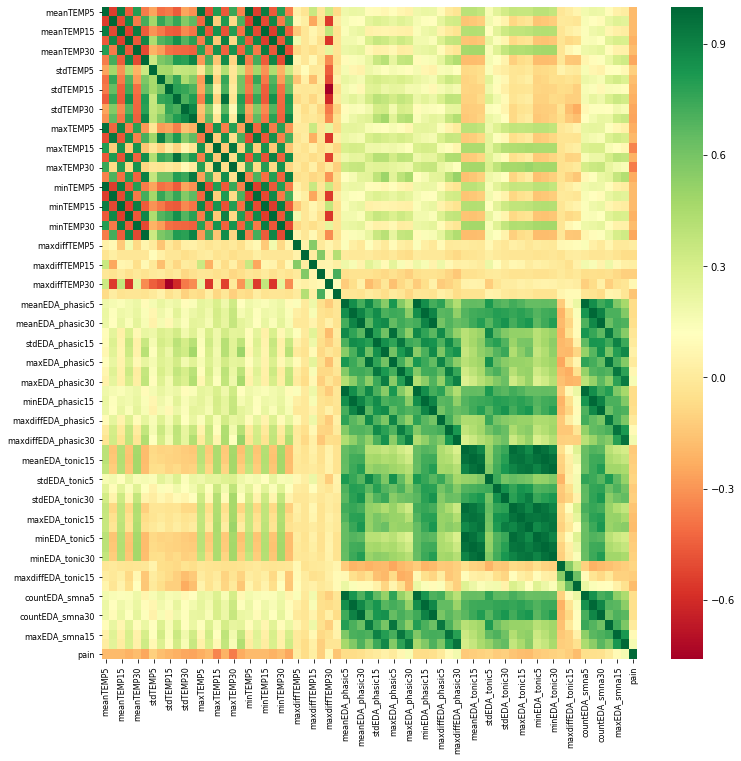

In [4]:
import seaborn as sns


plt.figure(figsize=(12,12))
hm = sns.heatmap(df.corr(),cmap='RdYlGn', annot=False)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 8)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 8)        
plt.show()

In [12]:
feature_sorted

,Feature,Score,p-values
16,maxTEMP30,199.462948,3.467313e-42
14,maxTEMP15,172.233753,5.347618e-37
11,stdHR30,86.570763,5.684162e-20
23,minHR30,83.201085,2.809309e-19
5,meanHR30,83.201085,2.809309e-19
10,stdTEMP30,82.714200,3.540250e-19
17,maxHR30,72.218958,5.303748e-17
12,maxTEMP5,71.920636,6.119619e-17
9,stdHR15,66.784515,7.232858e-16
15,maxHR15,63.190067,4.102683e-15


In [13]:
feature_sorted.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Documentos\feature_selection_filter.csv', index=None, header=True)